In [1]:
import sys
#sys.path.append("/home/bl9/gempy/")
#sys.path.append("C:/Users/Fabian/gempy/")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

from gempy import Topology

import vtk
import evtk

from scipy.interpolate import griddata

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[ 50,50,50],
                         path_f = "./input_data/Fab_ResModel_Foliations2.csv",
                         path_i = "./input_data/Fab_ResModel_Points2.csv")
geo_data.n_faults = 1

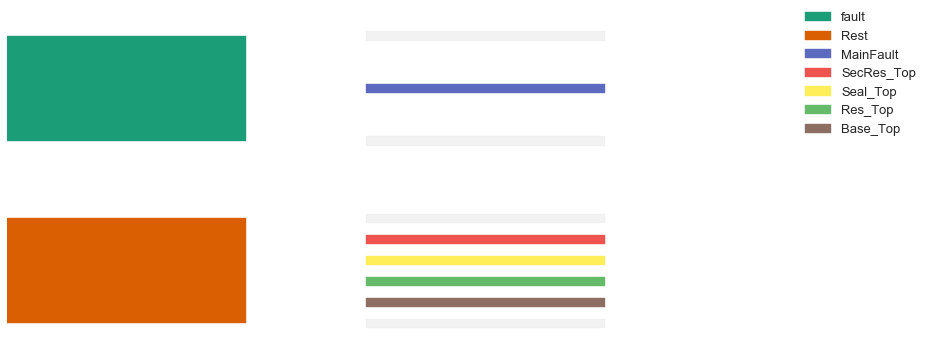

In [3]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ]) #for Fab_Test

In [4]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
geo_data.interfaces['fault side'] = 'nan'
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
nonfault_cond = geo_data.interfaces['formation'] != 'MainFault'
fault_cond = geo_data.interfaces['formation'] == 'MainFault'

fw_x_cond = geo_data.interfaces['X'] > (geo_data.extent[:2][1] - HW_border) # condition for FW points

hw_x_cond = geo_data.interfaces['X'] < (geo_data.extent[:2][1] - HW_border) # condition for HW points

geo_data.interfaces.set_value(fw_x_cond,'fault side','footwall') # setting FW
geo_data.interfaces.set_value(hw_x_cond,'fault side','hanging wall') #setting HW
geo_data.interfaces.set_value(fault_cond,'fault side','nan'); # reverting fault points to 'nan'

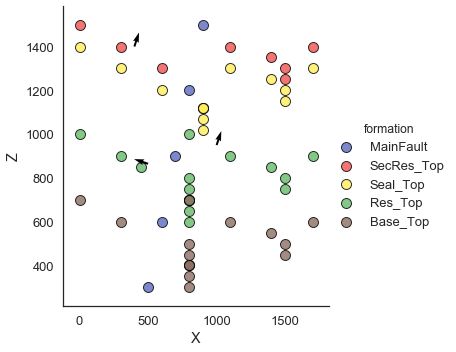

In [5]:
gp.plot_data(geo_data)

In [6]:
# INTERPOLATION
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3, 3],
                                   compile_theano=True, dtype ='float64')

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64


In [7]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

In [21]:
lith_holder = lith_sol
fault_holder = fault_sol
interp_holder = interp_data

In [23]:
# CREATING SURFACES FOR LAYERS
base_surf, base_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Base_Top']))
res_surf, res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Res_Top']))
seal_surf, seal_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Seal_Top']))
sec_res_surf, sec_res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['SecRes_Top']))

In [9]:
# 3D plot points in VTK
gp.plot_data_3D(geo_data)

In [14]:
# 3D plot points and surfaces in VTK
gp.plot_surfaces_3D(geo_data, [base_surf, sec_res_surf, seal_surf, res_surf], 
                    [base_surf_simp, sec_res_surf_simp, seal_surf_simp, res_surf_simp], plot_data=True)

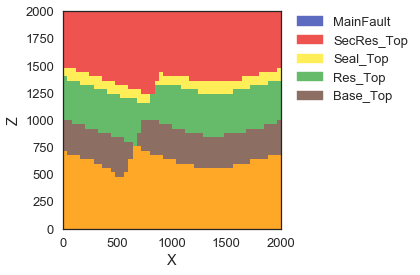

In [24]:
#%matplotlib notebook
%matplotlib inline
gp.plot_section(geo_data, lith_sol[0], 25, plot_data=0)

In [25]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

In [26]:
# FUNCTION TO FIND ANTICLINAL SPILL POINT AND CROSS-FAULT LEAK POINT

    #@staticmethod # possibly use to find saddle points!
    #def squared_euclidean_distances(x_1, x_2):
    #    """
    #    Compute the euclidian distances in 3D between all the points in x_1 and x_2
    #    Args:
    #        x_1 (theano.tensor.matrix): shape n_points x number dimension
    #        x_2 (theano.tensor.matrix): shape n_points x number dimension
#
    #    Returns:
    #        theano.tensor.matrix: Distancse matrix. shape n_points x n_points
    #    """
#
    #    # T.maximum avoid negative numbers increasing stability
    #    sqd = T.sqrt(T.maximum(
    #        (x_1**2).sum(1).reshape((x_1.shape[0], 1)) +
    #        (x_2**2).sum(1).reshape((1, x_2.shape[0])) -
    #        2 * x_1.dot(x_2.T), 0
    #    ))
#
    #    return sqd

def spill_leak_P(interp_data, res_surf, lith, fault, print_figures):    
    
    # creating a grid with uniform distances for vertices of the reservoir surface
    grid_x, grid_y = np.meshgrid(np.unique(interp_data.geo_data_res.grid.grid[:, 0]),
                             np.unique(interp_data.geo_data_res.grid.grid[:, 1]))

    grid_x=(grid_x*rescale_f)-(np.min(grid_x)*rescale_f)
    grid_y=(grid_y*rescale_f)-(np.min(grid_y)*rescale_f)
    
    grid_z0 = griddata(res_surf[:,:2], res_surf[:,2],
                       (grid_x, grid_y), method='linear')
    
    # order of values that serve to find relative extrema (min/max)
    rel_order_maxX = 5
    rel_order_maxY = 10
    rel_order_minX = 5
    rel_order_minY = 5
    
    # check grid_z0 for max and min in directions x and y
    # direction X
    minX1,minX2 = argrelextrema(grid_z0,np.less,order=rel_order_minX,axis=1)
    maxX1,maxX2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxX,axis=1)
    grid_minX = np.zeros_like(grid_z0)
    grid_minX[minX1,minX2]=1           # grid of min in X
    grid_maxX = np.zeros_like(grid_z0)
    grid_maxX[maxX1,maxX2]=1           # grid of max in X
    
    #direction Y
    minY1,minY2 = argrelextrema(grid_z0,np.less,order=rel_order_minY,axis=0)
    maxY1,maxY2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxY,axis=0)
    grid_minY = np.zeros_like(grid_z0)
    grid_minY[minY1,minY2]=1           # grid of min in Y
    grid_maxY = np.zeros_like(grid_z0)
    grid_maxY[maxY1,maxY2]=1           # grid of max in Y
    
    # fault leak line: defining line of juxtaposition, point of cross-fault leakage to be found on it
    # check for minima line that is on hanging wall side compared to max contact of layer top with fault
    fault_max_line_bool = np.copy(grid_maxX)
    fault_max_line = fault_max_line_bool.argmax(axis=1)
    fault_max = np.max(fault_max_line) # max of fault-layer contact as threshold        
    fleak_line = np.copy(grid_minX).astype(int)
    fleak_line[:,fault_max:]=0 # only returns minima at hanging wall side
    
    # minmax buffering - not used atm
    # supposed to set neighboring values of min and max to min and max respectively, too 
    if minmax_buffer:
        minXroll1 = np.logical_or(grid_minX,np.roll(grid_minX,1, axis=0))
        minXroll1[:,:fault_max] = 0
        minXroll2 = np.logical_or(grid_minX,np.roll(grid_minX,-1, axis=0))
        minXroll2[:,:fault_max] = 0
        minXbuffer = np.logical_or(minXroll1, minXroll2)
        grid_minX = np.logical_or(grid_minX, minXbuffer)
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,1))
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,-1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,-1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,1, axis=1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,-1, axis=1))
    
    #check for saddle points
    saddle_p1 = np.logical_and(grid_minX,grid_maxY)
    saddle_p2 = np.logical_and(grid_minY,grid_maxX)
    saddle_p_all= np.logical_or(saddle_p1, saddle_p2)
    
    # this should find saddle points relative to X and Y directions
    # problem of finding other points in a rotated direction?
    
    #fleak_line_z0 = grid_z0[fleak_line]
    #leak_max = fleak_line==np.nanargmax(fleak_line_z0)
    #print(np.nanargmax(fleak_line_z0))
    ### NOT FINISHED: DEFINE LEAK POINT OVER LEAK LINE MAX?
    
    # distinguish anticlinal spill points from fault leak points:
    pot_leak_points = np.logical_and(fleak_line,saddle_p_all)    
    pot_spill_points = saddle_p_all - pot_leak_points    # substracting leak bool from saddle point bool 
                                                    # to get spill point bool    
    # leak and spill point 3D coordinates
    # LEAK POINT
    #if juxtaposition_over_seal(lith, fault) == True: #check for juxtaposition with layers above seal (due to offset)
    
    pot_leak_Xcoord = grid_x[pot_leak_points]
    pot_leak_Ycoord = grid_y[pot_leak_points]
    pot_leak_Zcoord = grid_z0[pot_leak_points]    
    pot_leak_3Dcoord = np.array(list(zip(pot_leak_Xcoord, pot_leak_Ycoord, pot_leak_Zcoord)))
        
    if pot_leak_3Dcoord.size == 0:
        fault_leak_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
    else:
        max_leak_pos = pot_leak_3Dcoord[:,2].argmax(axis=0)
        fault_leak_3Dcoord = pot_leak_3Dcoord[max_leak_pos,:] # max is LP
        
    # SPILL POINT
    pot_spill_Xcoord = grid_x[pot_spill_points]
    pot_spill_Ycoord = grid_y[pot_spill_points]
    pot_spill_Zcoord = grid_z0[pot_spill_points]    
    pot_spill_3Dcoord = np.array(list(zip(pot_spill_Xcoord, pot_spill_Ycoord, pot_spill_Zcoord)))
    
    if pot_spill_3Dcoord.size == 0:
        anticline_spill_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
    else:
        max_spill_pos = pot_spill_3Dcoord[:,2].argmax(axis=0)
        anticline_spill_3Dcoord = pot_spill_3Dcoord[max_spill_pos,:] # max is SP
        
    #print('SP',anticline_spill_3Dcoord)
    #print('LP',fault_leak_3Dcoord)
    
    # PLOTTING (for visualization and checking)
    # plot of min/max bools and all potential LPs(+) and SPs(x):
    if print_figures==True:
        figsize(15,6)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        #ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, pot_spill_points, c="black", alpha = 1, marker='x', s = 250)
        ax.scatter(grid_x, grid_y, pot_leak_points, c="black", alpha = 1, marker='+', s = 250)
        #ax.scatter(grid_x, grid_y, fleak_line, c="b", alpha = 1, marker='+', s= 250)
        #ax.scatter(grid_x, grid_y, leak_max[2], c="g", alpha = 1, marker='+', s= 250)
        
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        
        plt.show()
    
        # plot of reservoir top surface and position of all potential LPs(+) and SPs(x):
        plot_spill_leak(res_surf, pot_spill_points, anticline_spill_3Dcoord, fault_leak_3Dcoord, grid_x, grid_y, grid_z0)
    
    return anticline_spill_3Dcoord, fault_leak_3Dcoord

In [38]:
# LITHOLOGY BLOCK MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith,fault, bottom_z, formation_nr):
    mask = np.ones_like(lith)
    mask[~formation_nr] = False
    mask[fault.astype(bool)] = False
    bottom_z = round((bottom_z/scale_factor)+0.5) # rounding up
    mask = mask.reshape(50,50,50)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(125000,)
    return mask

# Function that sets all voxels of lith_block which are equal (or closest to) to the spill_z
# horizontal as belonging to a separate "formation", to make sure the separation from border is given
# (the voxels are located on the border of reservoir and seal) (???):
#def set_spill_to_seal(geo_data, lith, max_z):
#    lith_spill = np.argmin(np.abs(geo_data.grid.grid[:, 2]-np.abs(max_z)))
#    bol_lith_spill = geo_data.grid.grid[:, 2] == geo_data.grid.grid[:, 2][lith_spill]
#    lith[bol_lith_spill] = 11 #for 11 instead of seal, to check - interp_data.get_formation_number()['Res_Top']
#    return lith
    # problem: this interferes with information entropy analysis
    # ideally, only trap border voxels would be altered, or possibly only one voxel necessary? How?

# Masking that confines the volume to ONLY those reservoir traps (from res_mask)
# that are NOT connected to the borders of the model (open system)
# Traps defined as CLOSED systems
#def topo_analysis(lith, fault, fault_seal):
#    #fig = plt.figure()
#    traps = []
#    # Padding of lith- and fault-block (creating border sections, formation number = 8)
#    lith_pad = (np.pad(lith.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
#    fault_pad = (np.pad(fault.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
#    topo = Topology.Topology(lith_pad, fault_pad, 1)
#    #G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot = gp.topology_analyze(lith_pad, fault_pad, 1)
#    #G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot = gp.topology_compute(geo_data, lith_pad, fault_pad)
#    topo_block = topo.labels
#    # Finding sections which are possible traps in the reservoir (formation number = 7)
#    trap_keys = [int(k) for k in topo.lith_to_labels_lot["7"].keys()] # potential trap sections
#    pad_keys = [int(p) for p in topo.lith_to_labels_lot["8"].keys()] # model border sections
#    secres_nr = interp_data.get_formation_number()['Seal_Top']
#    over_nr = interp_data.get_formation_number()['SecRes_Top']
#    secres_keys = [int(j) for j in topo.lith_to_labels_lot["%s" % secres_nr].keys()] # sections in Secondary Reservoir
#    over_keys = [int(o) for o in topo.lith_to_labels_lot["%s" % over_nr].keys()] # section in Overlying
#    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
#    bool_block = np.zeros_like(topo_block)
#    # Check for each possible trap section, if it is connected to a border
#    for tk in trap_keys:
#        #print('Checking Section:', tk)
#        juxta_counter = 0
#        # Check for adjacency to model border
#        if topo.check_adjacency(tk, pad_keys[0]) == False:
#            # Check for connection (juxtaposition!) to overlying layers (above seal)
#            if fault_seal == False: # if fault is sealing, juxtaposition is irrelevant
#                for ok in tot_over_keys:                    
#                    if topo.check_adjacency(tk, ok) == True: # check for juxtaposition
#                        print('JP found Trap section %s to overlying section %s.' % (tk, ok))
#                        juxta_counter += 1
#                if juxta_counter == 0:
#                    traps.append(tk) # TRAP is accepted, no JP, no connection to border
#                    print("No JP. TRAP FOUND, section:", tk)
#                else:
#                    print('Trap %s is juxtaposed --> leaking' % tk) # possible TRAP is discarded due to JP
#            else:
#                print("Fault SEALING, JP irrelevant. TRAP FOUND, section:", tk) 
#                traps.append(tk) # TRAP accepted, no check for JP necessary, no connection to border
#    if traps == []:
#        print('No trap found! =(')
#    else:
#        for i in traps:
#            # Creating a mask from the trap sections in the label block
#            top_bool = topo_block == i
#            bool_block[top_bool] = True
#    # Removing padding
#    trap_mask = bool_block[1:-1,1:-1,1:-1]
#    return trap_mask    # this mask returns True for all voxels which were accepted as trap voxels

def topo_analysis(lith, fault, fault_seal):
    #fig = plt.figure()
    traps = []
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    fault_pad = (np.pad(fault.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    topo = Topology.Topology(lith_pad, fault_pad, 1)
    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot = gp.topology_analyze(lith_pad, fault_pad, 1)
    topo_block = topo.labels
    # Finding sections which are possible traps in the reservoir (formation number = 7)
    trap_keys = [int(k) for k in lith_to_labels_lot["7"].keys()] # potential trap sections
    pad_keys = [int(p) for p in lith_to_labels_lot["8"].keys()] # model border sections
    secres_nr = interp_data.get_formation_number()['Seal_Top']
    over_nr = interp_data.get_formation_number()['SecRes_Top']
    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_nr].keys()] # sections in Secondary Reservoir
    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_nr].keys()] # section in Overlying
    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
    bool_block = np.zeros_like(topo_block)
    # Check for each possible trap section, if it is connected to a border
    for tk in trap_keys:
        #print('Checking Section:', tk)
        juxta_counter = 0
        # Check for adjacency to model border
        if gp.topology_check_adjacency(G, tk, pad_keys[0]) == False:
            # Check for connection (juxtaposition!) to overlying layers (above seal)
            if fault_seal == False: # if fault is sealing, juxtaposition is irrelevant
                for ok in tot_over_keys:                    
                    if gp.topology_check_adjacency(G, tk, ok) == True: # check for juxtaposition
                        print('JP found Trap section %s to overlying section %s.' % (tk, ok))
                        juxta_counter += 1
                if juxta_counter == 0:
                    traps.append(tk) # TRAP is accepted, no JP, no connection to border
                    print("No JP. TRAP FOUND, section:", tk)
                else:
                    print('Trap %s is juxtaposed --> leaking' % tk) # possible TRAP is discarded due to JP
            else:
                print("Fault SEALING, JP irrelevant. TRAP FOUND, section:", tk) 
                traps.append(tk) # TRAP accepted, no check for JP necessary, no connection to border
    if traps == []:
        print('No trap found! =(')
    else:
        for i in traps:
            # Creating a mask from the trap sections in the label block
            top_bool = topo_block == i
            bool_block[top_bool] = True
    # Removing padding
    trap_mask = bool_block[1:-1,1:-1,1:-1]
    return trap_mask    # this mask returns True for all voxels which were accepted as trap voxels

In [49]:
def juxtaposition_check(G, trap_tk, over_ok, seal_th):
    for ok in tot_over_keys:  
        if gp.topology_check_adjacency(G, tk, ok) == True:
            # check for adjacency area
            # related adj area (or fault throw?) to seal thickness
            # make sealing if within threshold and return trap or leakage

SyntaxError: unexpected EOF while parsing (<ipython-input-49-7eb44f7d370b>, line 6)

In [39]:
### ATTEMPT TO COME UP WITH SINGLE FUNCTION FOR JUXTAPOSITION AT THE BEGINNING STAGE OF FINDING RIGHT SPILL POINT
#def juxtaposition_over_seal(lith, fault):
#    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot = gp.topology_compute(geo_data, lith, fault)
#    res_nr = interp_data.get_formation_number()['Base_Top']
#    secres_nr = interp_data.get_formation_number()['Seal_Top']
#    over_nr = interp_data.get_formation_number()['SecRes_Top']
#    res_keys = [int(k) for k in lith_to_labels_lot["%s" % res_nr].keys()]
#    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_nr].keys()]
#    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_nr].keys()]
#    tot_over_keys = np.append(secres_keys, over_keys)
#    #print(res_keys)
#    #print(tot_over_keys)
#    top_counter = 0
#    gp.plot_section(geo_data, lith, 0)
#    gp.topology_plot(geo_data, G, centroids)
#    for rk in res_keys:
#        print('Checking for juxtapositions with overlying permeable layers for section:', rk)
#        # Saving enclosed sections as traps
#        for ok in tot_over_keys:
#            if gp.topology_check_adjacency(G, rk, ok) == True:
#                if G.adj[rk][ok]['edge_type'] == 'fault':
#                    top_counter += 1
#                    print("Juxtaposition of reservoir formation found:", rk, ok)
#            else:
#                print("No juxtaposition found!")
#    if top_counter == 0:
#        return False
#    else:
#        return True

In [40]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps

def max_trap_vol(interp_data, lith, fault, res_surface, fault_sealing):
    
    bottom_surface = np.ones_like(res_surface) # needed?   
    spill_point, leak_point = spill_leak_P(interp_data, res_surface, lith, fault, print_figures=False)
    #CHECK: ONLY CONTINUE IF SPILL POINT FOUND, ELSE RETURN ZERO TRAP VOLUME
    if spill_point.size == 0:
        spill_z = np.nan
        #print('No SPILL POINT found!')
        trap_vol = 0
        final_trap_mask = np.zeros_like(lith)
        return trap_vol, lith, bottom_surface, final_trap_mask    
    else:
        #print('SPILL POINT:',spill_point)
        spill_z = spill_point[2]
        #spill_z, spill_p, spill_min_line, spill_bottom = spill_point(res_surface)
        # calculate leak point
        if leak_point.size == 0:
            #print('No LEAK POINT found! So FULL LEAKAGE assumed!')
            #leak_z = np.nan
            leak_z = 2000
        else:
            #print('Leak Point:',leak_point)
            leak_z = leak_point[2]
        #leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surface)
        
        # Check for "down-to" z-horizon, maximum depth of reservoir
        # Check for fault sealing and subsequent relevance of leak point
        max_z = np.nanmax([spill_z, leak_z])
        if fault_sealing == True:
            if max_z == spill_z:
                print("Spill point defines trap.")
                print("Fault is sealing. Down to spill.")
                #bottom_surface = spill_bottom
            else:
                print("Fault leak point above spill point.")
                max_z = spill_z
                print("...but fault sealing. Down to spill.")
                #bottom_surface = spill_bottom
        else:
            if max_z == spill_z:
                print("Spill point defines trap.")
                print("Fault is pathway. Down to spill.")
                #bottom_surface = spill_bottom
            else:
                print("Fault leak point above spill point.")
                print("Cross-fault leakage. Down to leak.")
                #bottom_surface = leak_bottom      
        
        #print('Max_Z:', max_z)
        res_nr = lith == interp_data.get_formation_number()['Base_Top']
        pre_trap_mask = res_mask(lith, fault, max_z, res_nr)
          
        # volume cells for counting
        vol_cells = 0      
        
        pre_trap_mask_bool = (pre_trap_mask == True)
        # Check if there is anaything in the reservoir mask at all
        if np.count_nonzero(pre_trap_mask_bool) == 0:
            print("No res_formation above max_z!")
            return 0, lith, bottom_surface, pre_trap_mask
        else:
            lith[pre_trap_mask_bool] = 7                           # setting reservoir above bottom on footwall side 
                                                                # (incl. outside trap) to formation value = 7  
            #if max_z == spill_z:
            #lith = set_spill_to_seal(geo_data, lith, max_z)
            
            #test = lith.reshape(125000)                       
            #for i in range(len(test)):                         #to test pre-trap-masking volume
            #    if test[i] == 7:
            #        vol_cells +=1
            #res_vol = ((scale_factor)**3) * vol_cells 
            #print("VOLUME INCLUDING OUTSIDE TRAP:" ,res_vol)
            
            final_trap_mask = topo_analysis(lith, fault, fault_sealing)
            #lith[pre_trap_mask_bool] = 5
            lith[final_trap_mask] = 9                         # setting final trap to formation value = 9
            vol_cells = np.count_nonzero(final_trap_mask)
            
            #calulate volume from cells
            trap_vol = ((scale_factor)**3) * vol_cells 
            
            #return the maximum reservoir volume
            return trap_vol, lith, bottom_surface, final_trap_mask

In [41]:
# PLOTTING FUNCTIONS: Spill and leak point visualization
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:        
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

In [42]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)

# SAVING ORIGINAL Z-VALUES (so they are not overwritten and can be used a base for every iteration)    
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z']
base_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Base_Top']['Z']

#res_len = len(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z'])    

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP
unc_f = 1
std_secres_top = 20 #* unc_f
std_seal_top = 30 #* unc_f
std_res_top = 60 #* unc_f
std_base_top = 80 #* unc_f
z_unc_secres_top = pymc.Normal('z_unc_secres_top', 0, 1./np.square(std_secres_top/rescale_f))
z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0, 1./np.square(std_seal_top/rescale_f))
z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./np.square(std_res_top/rescale_f))
z_unc_base_top = pymc.Normal('z_unc_base_top', 0, 1./np.square(std_base_top/rescale_f))

# SETTING FAULT OFFSET UNCERTAINTY
std_offset = 75
offset_unc = pymc.Normal('offset_unc', -50/rescale_f, 1./np.square(std_offset/rescale_f))

# FAULT SEALING UNCERTAINTY (p = probability of success (1 = True); True = fault sealing)
fault_sealing = pymc.Bernoulli('fault_sealing_unc',p=.25)

In [43]:
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

# Combining hanging wall and formation conditions
HW_secres_top = np.logical_and(secres_top_cond,hanging_wall)
HW_seal_top = np.logical_and(seal_top_cond,hanging_wall)
HW_res_top = np.logical_and(res_top_cond,hanging_wall)
HW_base_top = np.logical_and(base_top_cond,hanging_wall)

#interp_data.geo_data_res.interfaces.set_value(HW_secres_top,'Z',25)

Z variations top to bottom: 10.9313873303 5.03914861816 -146.091663482 -25.30962268
Fault offset variation: -139.044330546
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to m

Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
Maximum reservoir volume: 18496000.0 m³


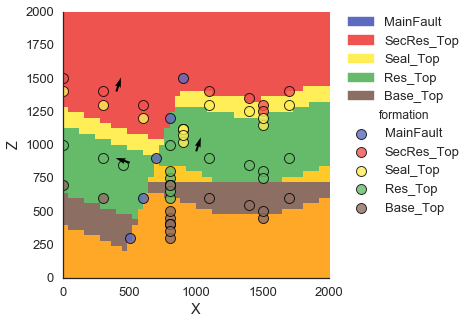

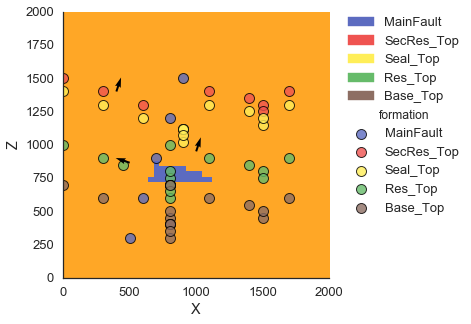

In [44]:
# PYMC MODEL FUNCTIONS 

# Updating of interp_data points with new z-values resulting from z-positional uncertainty
# and including offset uncertainty:
@pymc.deterministic
def interp_unc(value=0, z_unc_secres_top = z_unc_secres_top, z_unc_seal_top=z_unc_seal_top, 
                  z_unc_res_top = z_unc_res_top, z_unc_base_top = z_unc_base_top, off_unc=offset_unc):
    #print('CHECK0:', res_z)
    new_z_secres_top = sec_res_z + z_unc_secres_top
    new_z_seal_top = seal_z + z_unc_seal_top
    new_z_res_top = res_z + z_unc_res_top
    new_z_base_top = base_z + z_unc_base_top   
    
    # for offset uncertainty: additional change on hanging wall (HW): 
    HW_new_z_secres_top = new_z_secres_top + off_unc
    HW_new_z_seal_top = new_z_seal_top + off_unc
    HW_new_z_res_top = new_z_res_top + off_unc
    HW_new_z_base_top = new_z_base_top + off_unc
    
    print('Z variations top to bottom:', z_unc_secres_top*rescale_f, 
          z_unc_seal_top*rescale_f, z_unc_res_top*rescale_f, z_unc_base_top*rescale_f)
    
    print('Fault offset variation:', off_unc*rescale_f)
    #print('CHECK1:', new_z_res_top)
    #print('CHECK2:', HW_new_z_res_top)
    
    # FOOTWALL UNCERTAINTY
    interp_data.geo_data_res.interfaces.set_value(secres_top_cond,'Z',new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(seal_top_cond,'Z',new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(res_top_cond,'Z',new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(base_top_cond,'Z',new_z_base_top)
    
    # HANGING WALL UNCERTAINTY (incl. offset)
    interp_data.geo_data_res.interfaces.set_value(HW_secres_top,'Z',HW_new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(HW_seal_top,'Z',HW_new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(HW_res_top,'Z',HW_new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(HW_base_top,'Z',HW_new_z_base_top)
    
    #print('CHECK3:', interp_data.geo_data_res.interfaces)    
    return interp_data

# Calculating formation thickness based on z-difference between a bottom and top point on the footwall (fw)

# This is done using interp_data, where X,Y and Z-values are rescaled according to the rescaling_factor.
# Value[1] of extent_rescaled equals the maximum extent of model (here: 2000).
# So if we want to find the rescaled chosen X-position (here: 1100), 
# we simply calculate 2000-fw_th_point(here:900) rescaled (see fw_x)
# Y_mid defines that we are looking at a central position (in y-direction) in the model.
# The difference in z between two points has to be rescaled to the original scale again.
rescale_f = interp_data.rescaling_factor

# Reservoir thickness
@pymc.deterministic
def res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_sb_z-fw_rb_z)

#Seal thickness
@pymc.deterministic
def seal_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_r2b_z-fw_sb_z)

# Secondary reservoir thickness
@pymc.deterministic
def sec_res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    return np.abs(fw_ob_z-fw_r2b_z)

# Volumetric calculation 
@pymc.deterministic
def structural_model(interp_data_M=interp_unc, fault_sealing=fault_sealing, 
                     lh=lith_holder, fh=fault_holder, idh=interp_holder, print_figures=True):
    print('Fault sealing =', fault_sealing)
    try:
        lith_sol, fault_sol = gp.compute_model(interp_data_M)
        lith_block = lith_sol[0]
        fault_block = fault_sol[0]  
        res_top_surf, res_top_surf_simp = gp.get_surfaces(
                                              interp_data = interp_data_M, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = interp_data.get_formation_number()['Res_Top'])
        max_vol, lith_sol[0], bottom, trap = max_trap_vol(interp_data_M, lith_block, fault_block, res_top_surf, fault_sealing)
        print("Maximum reservoir volume: %s m³" % max_vol)
        #gp.plot_section(geo_data, lith_sol[0,0], 5, plot_data =1)
        #gp.plot_section(geo_data, lith_sol[0,0], 45, plot_data =1)
        if print_figures == True:
            gp.plot_section(geo_data, lith_sol[0], 25, plot_data =1)
            gp.plot_section(geo_data, trap, 25, plot_data =1)
        return lith_sol, fault_sol, max_vol, trap
    except np.linalg.linalg.LinAlgError as err:
        # In case of LinAlgError, use original model
        print('LinAlgError occurred!')
        lith_sol = lh
        fault_sol = fh
        lith_block = lith_sol[0]
        fault_block = fault_sol[0] 
        res_top_surf, res_top_surf_simp = gp.get_surfaces(
                                              interp_data = idh, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = interp_data.get_formation_number()['Res_Top'])
        max_vol, lith_sol[0], bottom, trap = max_trap_vol(idh, lith_block, fault_block, res_top_surf, fault_sealing)
        print("Maximum reservoir volume: %s m³" % max_vol)
        return lith_sol, fault_sol, max_vol, trap
        
# Avoid layer inversion by giving negative thicknesses a likelihood of zero
#@pymc.deterministic
#def no_inversion(sec_res_th=sec_res_th, res_th=res_th, seal_th=seal_th)

In [47]:
iterations = 20

In [46]:
model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, fault_sealing, structural_model, res_th, seal_th, sec_res_th])

Z variations top to bottom: 0.525044678419 13.3608503591 23.9460375197 42.1630144131
Fault offset variation: -105.775773213
Fault sealing = False


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to m

Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 10 to overlying section 5.
JP found Trap section 10 to overlying section 6.
Trap 10 is juxtaposed --> leaking
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---              10%                  ] 2 of 20 complete in 5.3 secZ variations top to bottom: 17.6783761336 19.4124401217 7.17578697635 65.9238498882
Fault offset variation: -31.2633333398
Fault sealing = False
Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 10 to overlying section 5.
Trap 10 is juxtaposed --> leaking
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----            15%                  ] 3 of 20 complete in 10.6 secZ variations top to bottom: 18.5651911696 24.7104523462 -79.8683308564 -99.8938936577
Fault offset variation: -57.4975281463
Fault sealing = False
Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
Maximum reservoir volume: 25216000.0 m³
 [--

C:\Users\Fabian\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 [-----------------60%--                ] 12 of 20 complete in 58.1 secZ variations top to bottom: 20.3059682066 -11.436364374 -114.424164415 -49.9263047675
Fault offset variation: -201.034667901
Fault sealing = False
Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 10 to overlying section 5.
Trap 10 is juxtaposed --> leaking
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------65%----              ] 13 of 20 complete in 63.5 secZ variations top to bottom: -2.69404057471 64.149457729 42.8315880516 22.3416780936
Fault offset variation: -61.4297926
Fault sealing = False
Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 10 to overlying section 5.
Trap 10 is juxtaposed --> leaking
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------70%------            ] 14 of 20 complete in 68.7 secZ variations top to bottom: 31.8998612932 -8.01417676956 -49.9312001491 -36.8203402327
Fault offset variation: 3

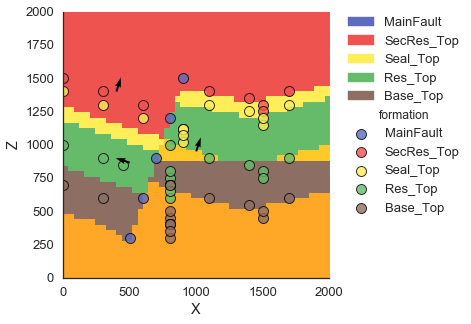

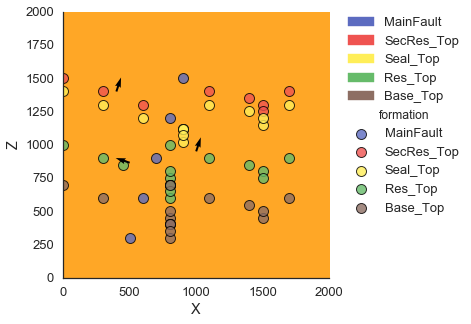

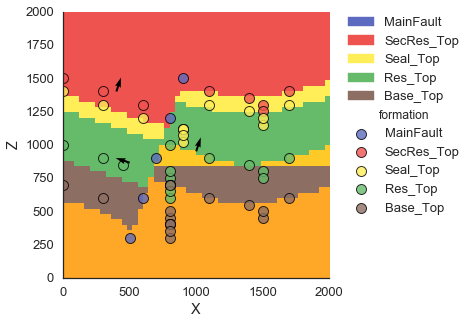

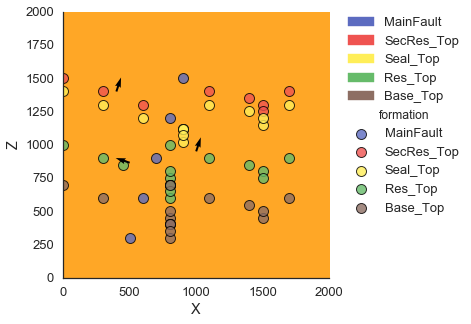

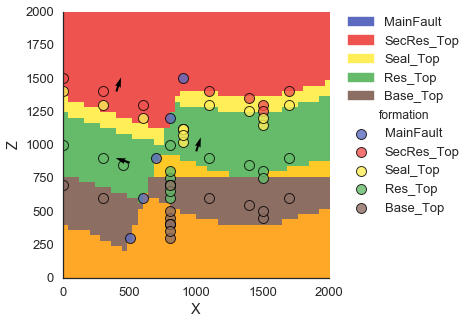

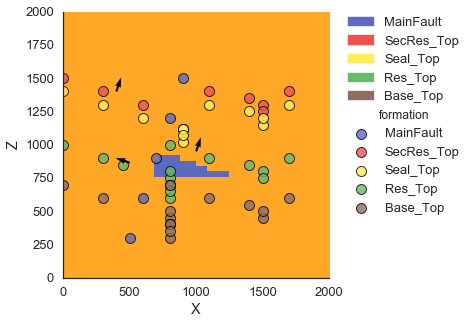

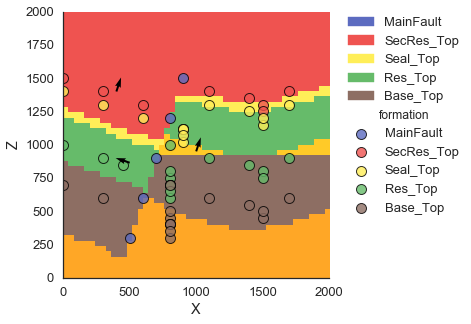

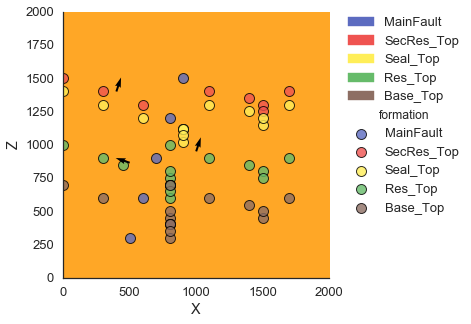

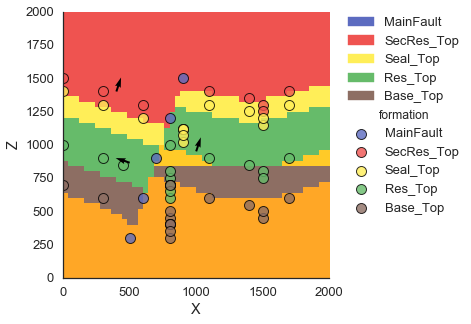

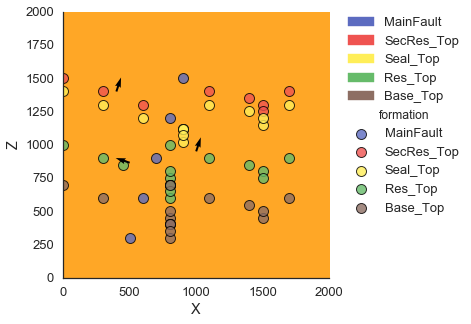

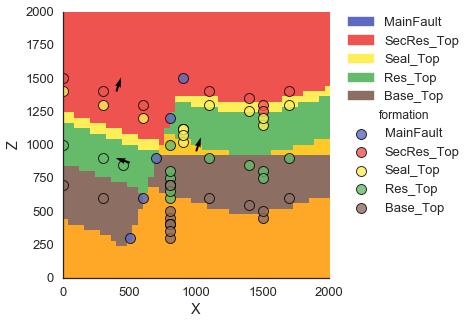

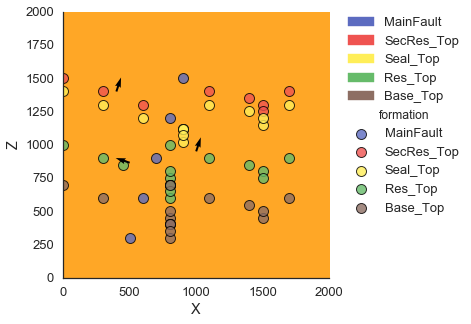

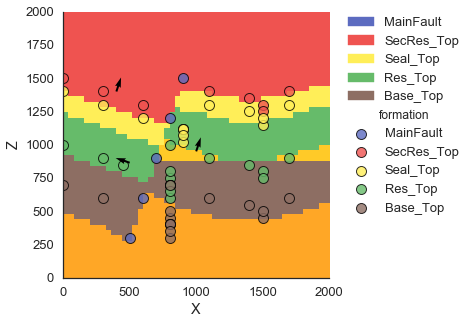

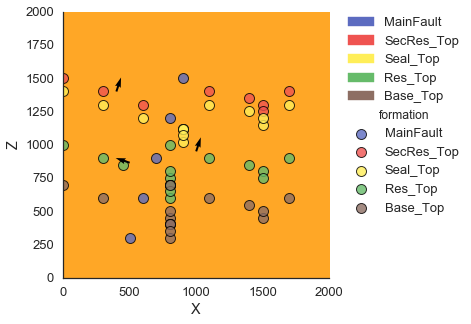

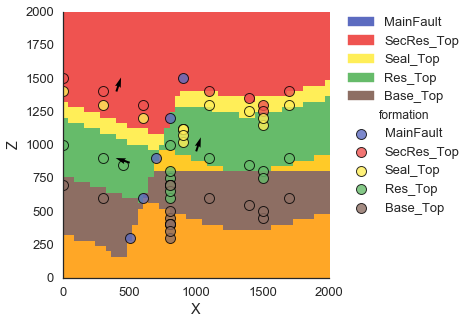

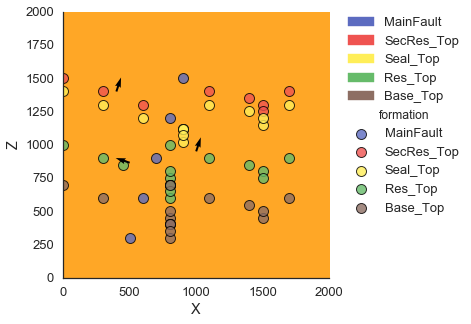

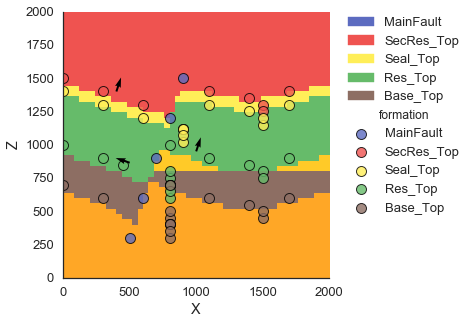

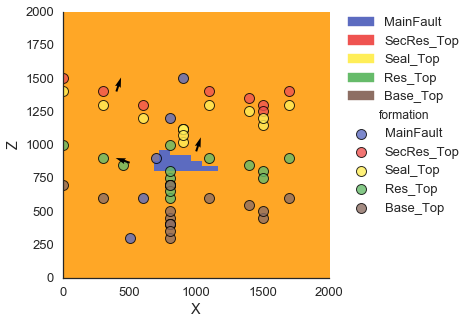

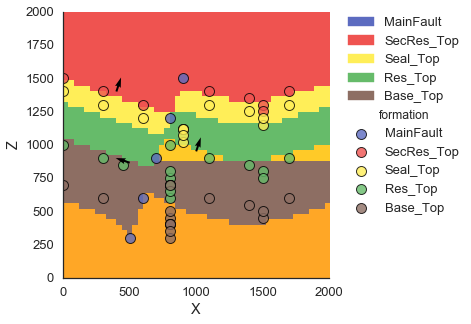

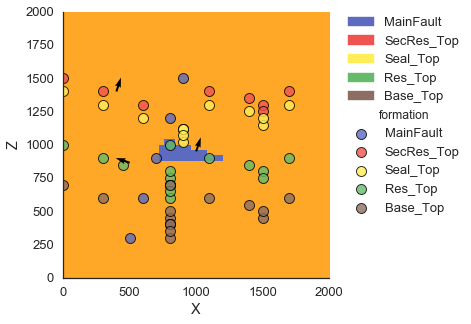

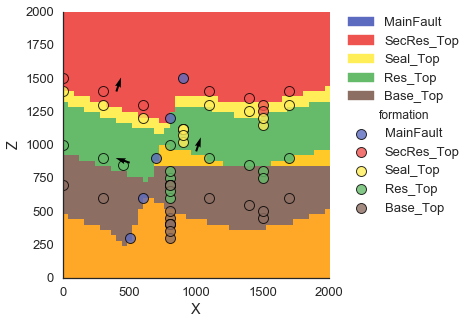

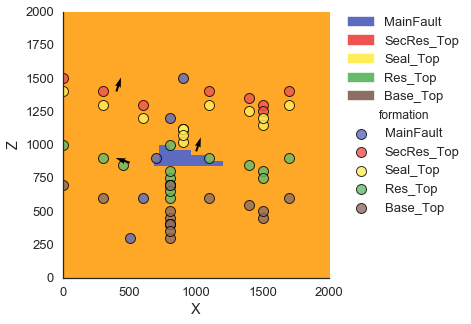

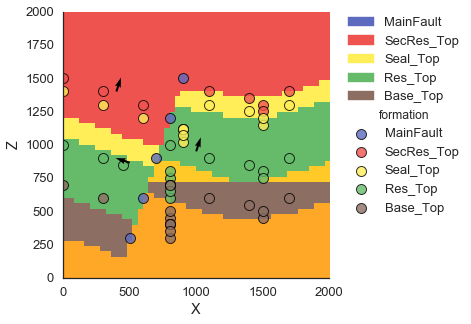

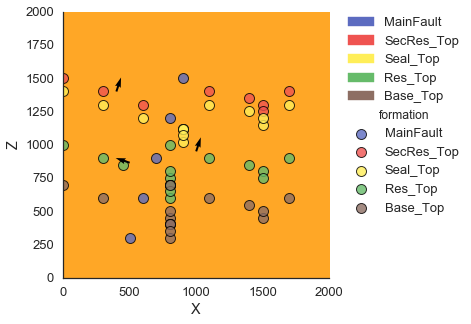

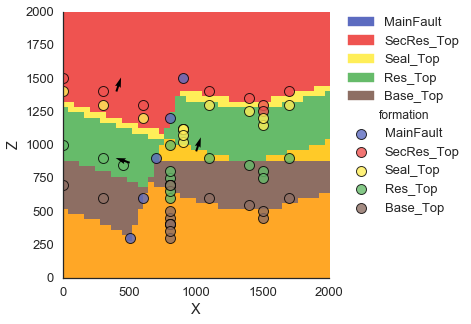

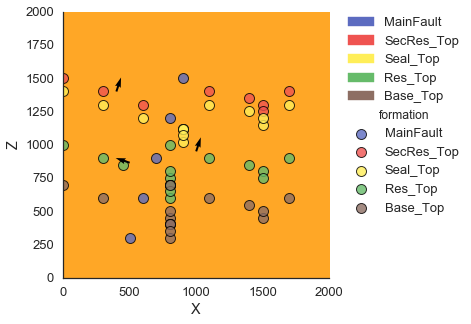

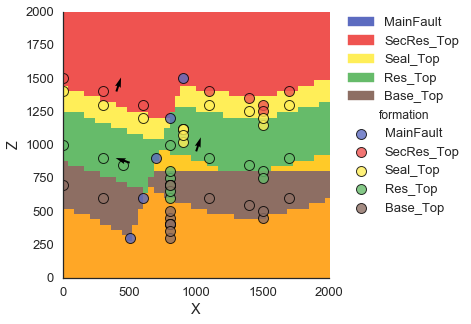

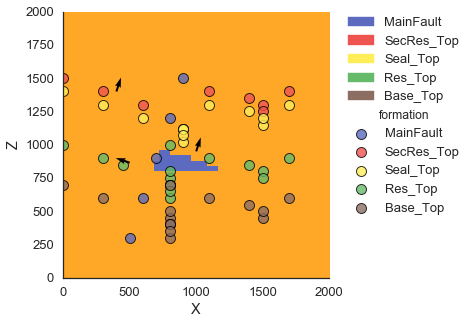

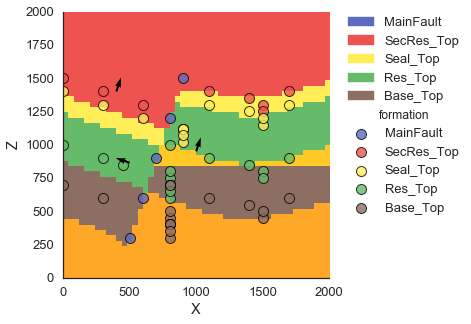

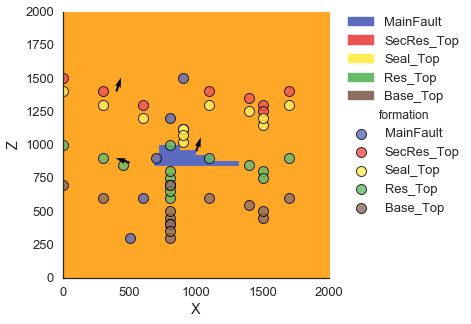

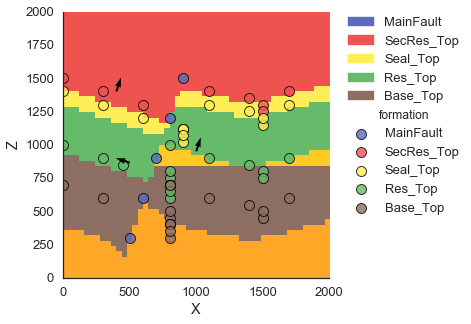

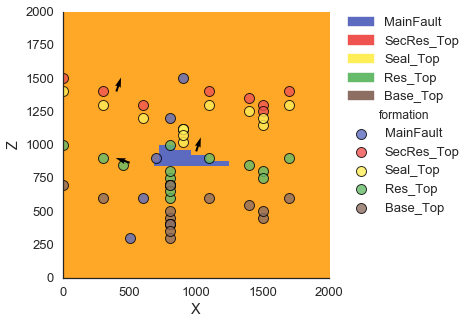

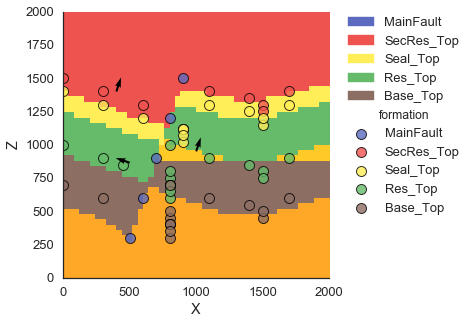

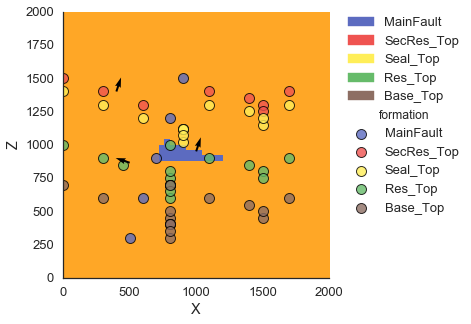

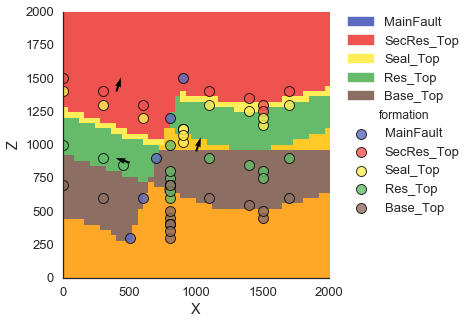

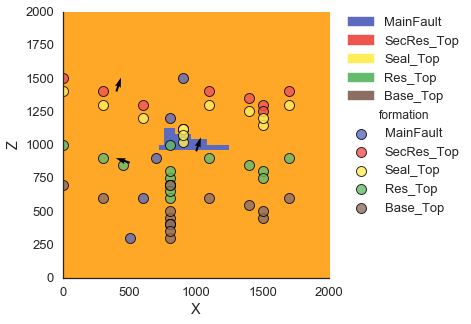

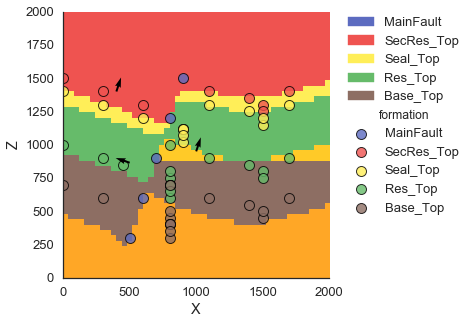

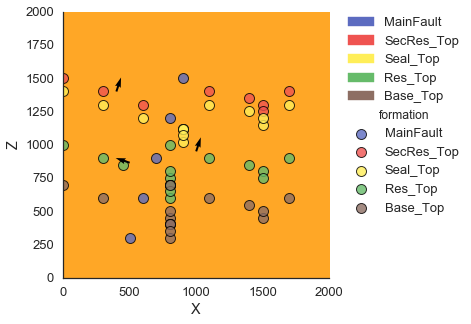

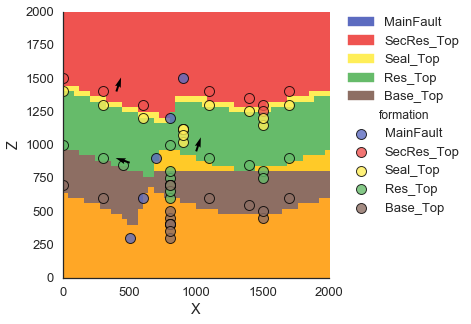

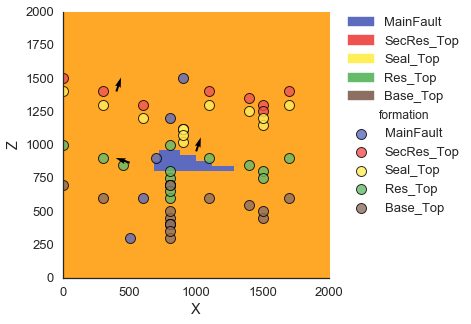

In [48]:
M = pymc.MCMC(model)
M.sample(iter=iterations)

In [40]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
offset_unc_trace = M.trace('offset_unc')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
structural_model_trace = M.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume,[3]=trap_block

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

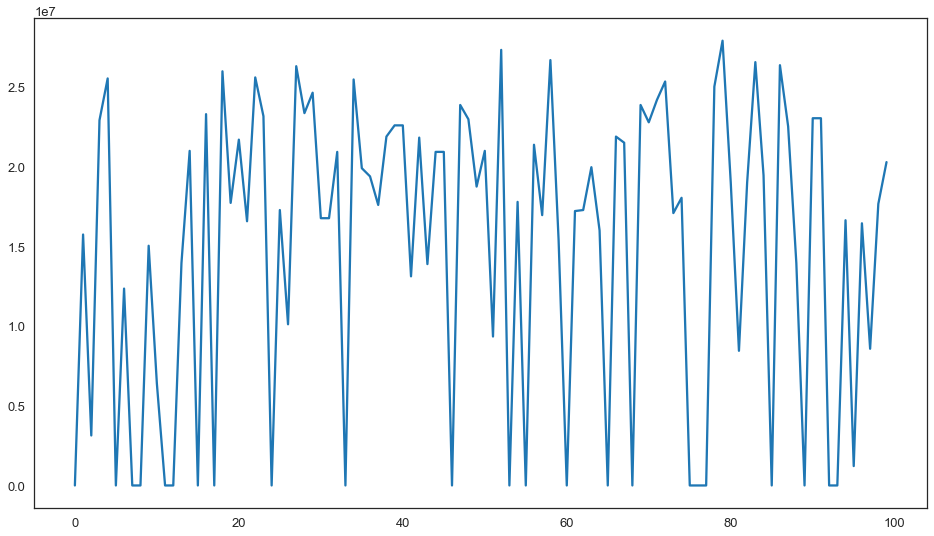

In [41]:
max_volume_trace = structural_model_trace[:,2]
plt.plot(max_volume_trace)

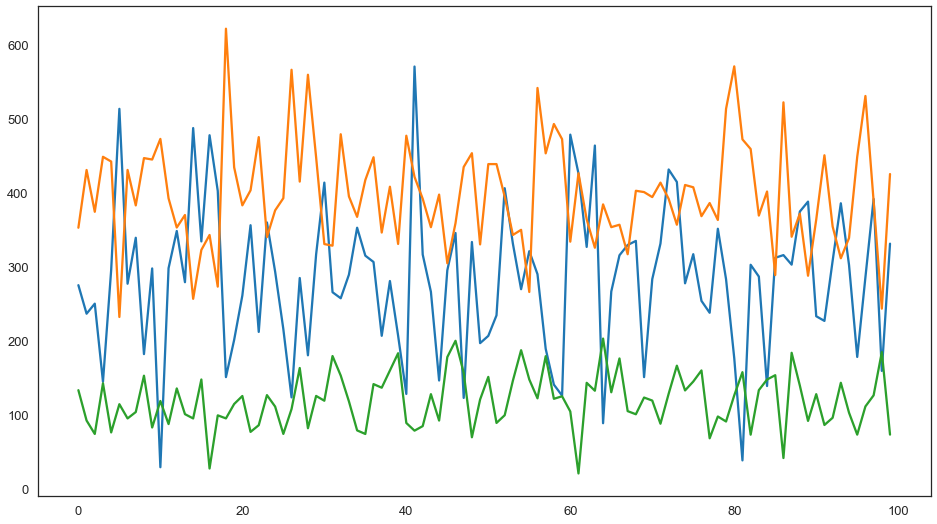

In [42]:
plt.plot(fw_res_th_trace)
plt.plot(fw_seal_th_trace)
plt.plot(fw_sec_res_th_trace)

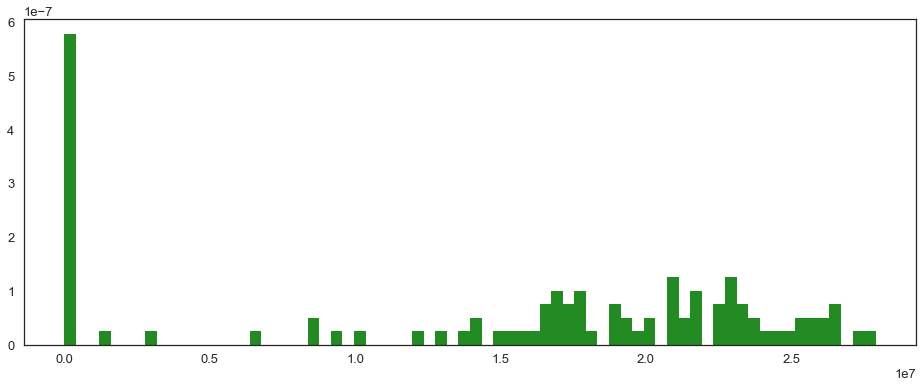

In [43]:
figsize(16, 6)

#_hist1 = plt.hist(max_volume_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")
volumes = max_volume_trace
mask = volumes == 0
masked_trace = volumes[~mask]
_hist1 = plt.hist(max_volume_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "forestgreen")
#_hist1 = plt.hist(masked_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

In [92]:
#import datetime
counter = 0
for i in structural_model_trace[:]:
    counter+=1
    #print(np.ascontiguousarray(i[3]))
    gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[3]), path="./output_data/trap_volumes/21_10B-TRAP_25iterUNC_LIKELIHOOD_%s" % (counter))
    gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[0][0]), path="./output_data/lith_blocks/21_10B-LITH_25iterUNC_LIKELIHOOD_%s" % (counter))

In [29]:
# INFORMATION ENTROPY FUNCTIONS
def compute_prob_lith(lith_blocks):
    """Blocks must be just the lith blocks!"""
    lith_id = np.unique(lith_blocks)
    lith_count = np.zeros_like(lith_blocks[0:len(lith_id)])
    for i, l_id in enumerate(lith_id):
        lith_count[i] = np.sum(lith_blocks == l_id, axis=0)
    lith_prob = lith_count / len(lith_blocks)
    return lith_prob


def calculate_ie_masked(lith_prob):
    ie = np.zeros_like(lith_prob[0])
    for l in lith_prob:
        pm = np.ma.masked_equal(l, 0)  # mask where layer prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie


def calculate_ie_total(ie, absolute=False):
    if absolute:
        return np.sum(ie)
    else:
        return np.sum(ie) / np.size(ie)

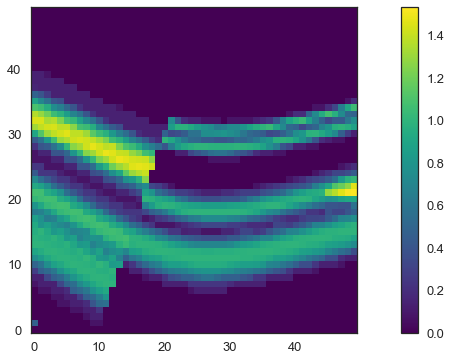

In [31]:
lith_blocks = []
for i in structural_model_trace[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0].astype(int))

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

plt.imshow(i_entropy.reshape(50,50,50)[:,0,:].T, origin="lower", cmap="viridis")
plt.colorbar()

In [32]:
#LOSS FUNCTIONS
estimates_s = np.arange(0,60000000, 10000)

#weight factors
ov = 1.25
ov_b = 2
uv_b = 1.5

#risk parameters
risks_s = np.arange(0.5, 1.6, 0.25)

#risk neutral
def volume_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*uv_b
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s

#including risk
def volume_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s == 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s == 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = np.abs((true_s[overest_bad]-estimate_s))*(ov_b*risk_s)
        return loss_s
    
#def volume_lossR(estimate_s, true_s, risk_s):
#        loss_s = np.zeros_like(true_s)
#        underest = (estimate_s < true_s) 
#        underest_bad = (estimate_s <= 0) & (true_s > 0)
#        overest = (estimate_s > true_s) 
#        overest_bad = (estimate_s > 0) & (true_s <= 0)
#        loss_s[underest] = (true_s[underest] - estimate_s)
#        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
#        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
#        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
#        return loss_s

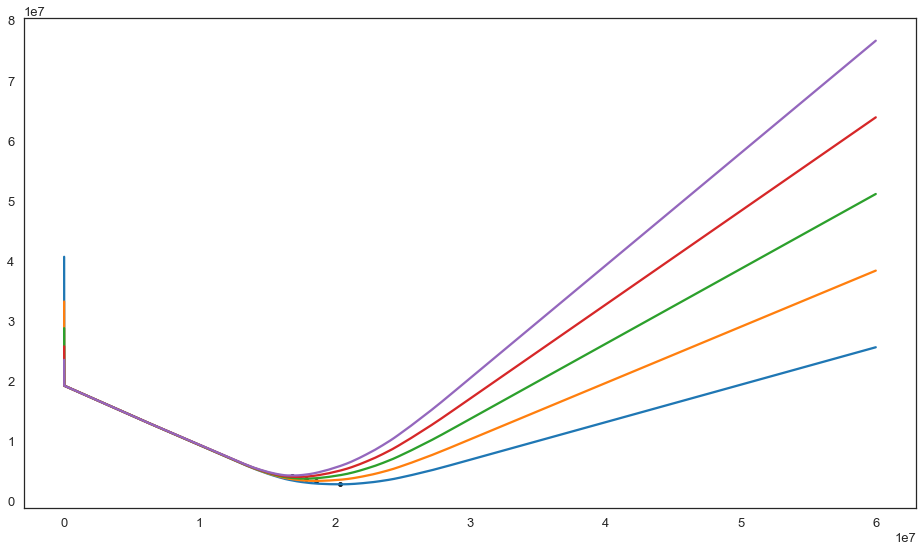

In [33]:
figsize(16, 9)

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss = lambda estimate_s, risk_s: volume_lossR(estimate_s, masked_trace, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss, -40, args=(r,),disp = False)
    #print(_min_score)
    if _min_score < 0:
        _min_score = 0
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss(_min_score,r)
    counter += 1


In [20]:
# THICKNESS LIKELIHOOD FUNCTIONS
#Additional information, updating with likelihoods

#return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z

std1 = 10
std2 = 20
std3 = 15

@pymc.stochastic
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(sec_res_th, 120., 1./np.square(std1))

@pymc.stochastic
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(seal_th, 400., 1./np.square(std2))

@pymc.stochastic
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(res_th, 250., 1./np.square(std3))

In [21]:
#model = pymc.Model([pos_unc_model, z_unc_res_top, fault_sealing, fw_th, hw_th, 
#                    res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                    fault_sealing, structural_model, 
                    res_th, seal_th, sec_res_th, 
                    res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])

In [22]:
iterations=110

In [23]:
M_L = pymc.MCMC(model_L)
M_L.sample(iter=iterations, burn=10)

Z variations top to bottom: -4.82337583861 -3.11278841724 68.2943841405 -77.3479585026
Fault offset variation: 83.2738842393
Z variations top to bottom: -4.82337583861 -3.11278841724 68.2943841405 -73.0609458521
Fault offset variation: 83.2738842393
Z variations top to bottom: -4.82337583861 -3.11278841724 -31.5043999739 -73.0609458521
Fault offset variation: 83.2738842393
Z variations top to bottom: -4.82337583861 -3.11278841724 -31.5043999739 -73.0609458521
Fault offset variation: 222.021012651

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to m


Z variations top to bottom: -7.2068283328 -3.11278841724 -31.5043999739 -73.0609458521
Fault offset variation: 83.2738842393
Z variations top to bottom: -7.2068283328 7.69632084983 -31.5043999739 -73.0609458521
Fault offset variation: 83.2738842393
Z variations top to bottom: -7.2068283328 -3.11278841724 -31.5043999739 -145.436367126
Fault offset variation: 83.2738842393
Z variations top to bottom: -7.2068283328 -3.11278841724 38.6691923047 -73.0609458521
Fault offset variation: 83.2738842393
Z variations top to bottom: -7.2068283328 -3.11278841724 -31.5043999739 -73.0609458521
Fault offset variation: -38.8666777796
Z variations top to bottom: -17.3551719501 -3.11278841724 -31.5043999739 -73.0609458521
Fault offset variation: -38.8666777796
Z variations top to bottom: -7.2068283328 3.73792765631 -31.5043999739 -73.0609458521
Fault offset variation: -38.8666777796
Z variations top to bottom: -7.2068283328 -3.11278841724 -31.5043999739 -212.042759105
Fault offset variation: -38.86667777

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
Maximum reservoir volume: 16512000.0 m³
 [----             10%                  ] 12 of 110 complete in 6.4 secZ variations top to bottom: -12.2982630259 -36.1776598731 -70.5039214381 -35.0322806014
Fault offset variation: -15.3042087376
Z variations top to bottom: -12.2982630259 -36.1776598731 -70.5039214381 0.313637961126
Fault offset variation: -15.3042087376
Z variations top to bottom: -12.2982630259 -36.1776598731 -37.8876391156 -35.0322806014
Fault offset variation: -15.3042087376
Z variations top to bottom: -12.2982630259 -36.1776598731 -70.5039214381 -35.0322806014
Fault offset variation: -34.6502943633
Z variations top to bottom: -21.2846252461 -36.1776598731 -70.5039214381 -35.0322806014
Fault offset variation: -34.6502943633
Fault sealing = False
Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
Maximum reservoir volume: 16512000.0 m³
 [----      

Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
Maximum reservoir volume: 19008000.0 m³
 [-------          20%                  ] 22 of 110 complete in 53.0 secZ variations top to bottom: -19.1592520182 -44.7764733488 -62.4233233639 -18.9429000147
Fault offset variation: -36.5583558032
Z variations top to bottom: -19.1592520182 -44.7764733488 -62.4233233639 58.7787371464
Fault offset variation: -36.5583558032
Z variations top to bottom: -19.1592520182 -44.7764733488 -164.461301288 -18.9429000147
Fault offset variation: -36.5583558032
Z variations top to bottom: -19.1592520182 -44.7764733488 -62.4233233639 -18.9429000147
Fault offset variation: -126.418165731
Z variations top to bottom: -21.5800930246 -44.7764733488 -62.4233233639 -18.9429000147
Fault offset variation: -126.418165731
Fault sealing = True
Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 10
Maximum reservoir volume: 1900

C:\Users\Fabian\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


No JP. TRAP FOUND, section: 10
Maximum reservoir volume: 19008000.0 m³
 [-----------      29%                  ] 32 of 110 complete in 99.7 secZ variations top to bottom: -17.6358711357 -36.490915591 -62.4043603218 -7.71202773027
Fault offset variation: -98.6233233586
Z variations top to bottom: -17.6358711357 -36.490915591 -62.4043603218 -68.0181248015
Fault offset variation: -98.6233233586
Z variations top to bottom: -17.6358711357 -36.490915591 -243.013565564 -7.71202773027
Fault offset variation: -98.6233233586
Z variations top to bottom: -17.6358711357 -36.490915591 -62.4043603218 -7.71202773027
Fault offset variation: -299.6963199
Z variations top to bottom: -17.6358711357 -36.490915591 -62.4043603218 -7.71202773027
Fault offset variation: -98.6233233586
Z variations top to bottom: -17.8875808768 -36.490915591 -62.4043603218 -7.71202773027
Fault offset variation: -98.6233233586
Fault sealing = False
Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, sec

Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
Maximum reservoir volume: 18624000.0 m³
 [--------------   37%                  ] 41 of 110 complete in 141.9 secZ variations top to bottom: -4.28592045063 -26.3797990725 -63.9511917193 -19.2693278766
Fault offset variation: 2.49561140252
Z variations top to bottom: -4.28592045063 -26.3797990725 -63.9511917193 -178.132551661
Fault offset variation: 2.49561140252
Z variations top to bottom: -4.28592045063 -26.3797990725 -43.2368851344 -19.2693278766
Fault offset variation: 2.49561140252
Z variations top to bottom: -4.28592045063 -26.3797990725 -43.2368851344 -19.2693278766
Fault offset variation: 1.6619932056
Z variations top to bottom: 3.74622277159 -26.3797990725 -43.2368851344 -19.2693278766
Fault offset variation: 1.6619932056
Fault sealing = True
Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 10
Maximum reservoir volume: 24448000.0

Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
Maximum reservoir volume: 22592000.0 m³
 [-----------------45%                  ] 50 of 110 complete in 184.1 secZ variations top to bottom: 0.081006417645 -24.8517599701 -5.76999919383 37.3379456291
Fault offset variation: -27.4274226986
Z variations top to bottom: 0.081006417645 -21.3027157507 -5.76999919383 45.5070562224
Fault offset variation: -27.4274226986
Z variations top to bottom: 0.081006417645 -21.3027157507 -37.3964146401 45.5070562224
Fault offset variation: -27.4274226986
Z variations top to bottom: 0.081006417645 -21.3027157507 -5.76999919383 45.5070562224
Fault offset variation: 32.4210326223
Z variations top to bottom: -4.81020898311 -21.3027157507 -5.76999919383 45.5070562224
Fault offset variation: 32.4210326223
Fault sealing = True
Spill point defines trap.
Fault is sealing. Down to spill.
Fault SEALING, JP irrelevant. TRAP FOUND, section: 10
Maximum reservoir volume: 22528000.

Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
Maximum reservoir volume: 26432000.0 m³
 [-----------------54%                  ] 60 of 110 complete in 231.0 secZ variations top to bottom: 14.9257721293 -6.95425818903 -37.7243294211 20.6745831323
Fault offset variation: -66.3232473971
Z variations top to bottom: 14.9257721293 -6.95425818903 -37.7243294211 -28.751331959
Fault offset variation: -66.3232473971
Z variations top to bottom: 14.9257721293 -6.95425818903 -96.7406027813 20.6745831323
Fault offset variation: -66.3232473971
Z variations top to bottom: 14.9257721293 -6.95425818903 -37.7243294211 20.6745831323
Fault offset variation: -124.293296511
Z variations top to bottom: 14.9257721293 -6.95425818903 -37.7243294211 20.6745831323
Fault offset variation: -66.3232473971
Z variations top to bottom: 20.1808640763 -6.95425818903 -37.7243294211 20.6745831323
Fault offset variation: -66.3232473971
Fault sealing = False
Spill point defines trap.

JP found Trap section 10 to overlying section 5.
Trap 10 is juxtaposed --> leaking
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------62%---               ] 69 of 110 complete in 273.1 secZ variations top to bottom: 4.25047000171 -2.58560865696 -16.2134863963 15.2743038293
Fault offset variation: -202.338774677
Z variations top to bottom: 4.25047000171 -2.58560865696 -16.2134863963 170.203316787
Fault offset variation: -202.338774677
Z variations top to bottom: 4.25047000171 -2.58560865696 -59.8335537824 15.2743038293
Fault offset variation: -202.338774677
Z variations top to bottom: 4.25047000171 -2.58560865696 -16.2134863963 15.2743038293
Fault offset variation: -163.532040882
Z variations top to bottom: 9.13424001954 -2.58560865696 -16.2134863963 15.2743038293
Fault offset variation: -163.532040882
Fault sealing = False
Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 10 to overlying section 5.
Trap 10 is juxtaposed --> leaking
No t

Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 10 to overlying section 5.
Trap 10 is juxtaposed --> leaking
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [-----------------70%------            ] 78 of 110 complete in 314.8 secZ variations top to bottom: 7.6668994729 -11.2309938641 -15.5181674251 35.8712749064
Fault offset variation: -118.92583821
Z variations top to bottom: 7.6668994729 -11.2309938641 -15.5181674251 35.9161340776
Fault offset variation: -118.92583821
Z variations top to bottom: 7.6668994729 -11.2309938641 -144.80068036 35.9161340776
Fault offset variation: -118.92583821
Z variations top to bottom: 7.6668994729 -11.2309938641 -15.5181674251 35.9161340776
Fault offset variation: -125.145201511
Z variations top to bottom: 10.1888746748 -11.2309938641 -15.5181674251 35.9161340776
Fault offset variation: -125.145201511
Fault sealing = False
Spill point defines trap.
Fault is pathway. Down to spill.
JP found Trap section 10 to overlyin

Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
Maximum reservoir volume: 17792000.0 m³
 [-----------------79%----------        ] 87 of 110 complete in 356.6 secZ variations top to bottom: 25.0428972713 -16.5506147274 -22.2110516333 18.7354230817
Fault offset variation: -43.6784743979
Z variations top to bottom: 25.0428972713 -16.5506147274 -22.2110516333 69.1457291581
Fault offset variation: -43.6784743979
Z variations top to bottom: 25.0428972713 -16.5506147274 -197.577482197 18.7354230817
Fault offset variation: -43.6784743979
Z variations top to bottom: 25.0428972713 -16.5506147274 -22.2110516333 18.7354230817
Fault offset variation: -1.65106214696
Z variations top to bottom: 17.6248533895 -16.5506147274 -22.2110516333 18.7354230817
Fault offset variation: -1.65106214696
Fault sealing = False
Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
Maximum reservoir volume: 17792000.0 m³
 [-----------------8

Spill point defines trap.
Fault is pathway. Down to spill.
No JP. TRAP FOUND, section: 10
Maximum reservoir volume: 20992000.0 m³
 [-----------------96%----------------  ] 106 of 110 complete in 444.6 secZ variations top to bottom: -16.4739167415 -33.3009678598 -11.4207150132 29.1530638479
Fault offset variation: -86.4695748645
Z variations top to bottom: -16.4739167415 -33.3009678598 -11.4207150132 63.3366285096
Fault offset variation: -86.4695748645
Z variations top to bottom: -16.4739167415 -33.3009678598 52.018476222 29.1530638479
Fault offset variation: -86.4695748645
Z variations top to bottom: -16.4739167415 -33.3009678598 -11.4207150132 29.1530638479
Fault offset variation: 101.375609497
Z variations top to bottom: -16.4739167415 -33.3009678598 -11.4207150132 29.1530638479
Fault offset variation: -86.4695748645
Z variations top to bottom: -16.3087487066 -33.3009678598 -11.4207150132 29.1530638479
Fault offset variation: -86.4695748645
Fault sealing = False
Spill point defines t

In [24]:
res_top_unc_trace_L = M_L.trace('z_unc_res_top')[:]
offset_unc_trace_L = M_L.trace('offset_unc')[:]
fault_sealing_trace_L = M_L.trace('fault_sealing_unc')[:]
structural_model_trace_L = M_L.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume

fw_res_th_trace_L = M_L.trace('res_th')[:]
fw_seal_th_trace_L = M_L.trace('seal_th')[:]
fw_sec_res_th_trace_L = M_L.trace('sec_res_th')[:]

interp_trace_L = M_L.trace('interp_unc')[:]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

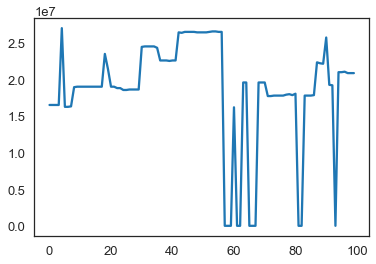

In [25]:
max_volume_trace_L = structural_model_trace_L[:,2]
plt.plot(max_volume_trace_L)

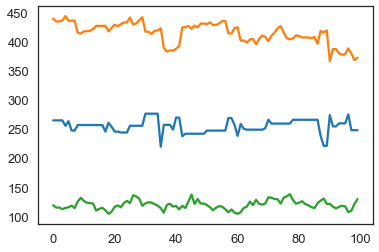

In [26]:
plt.plot(fw_res_th_trace_L)
plt.plot(fw_seal_th_trace_L)
plt.plot(fw_sec_res_th_trace_L)

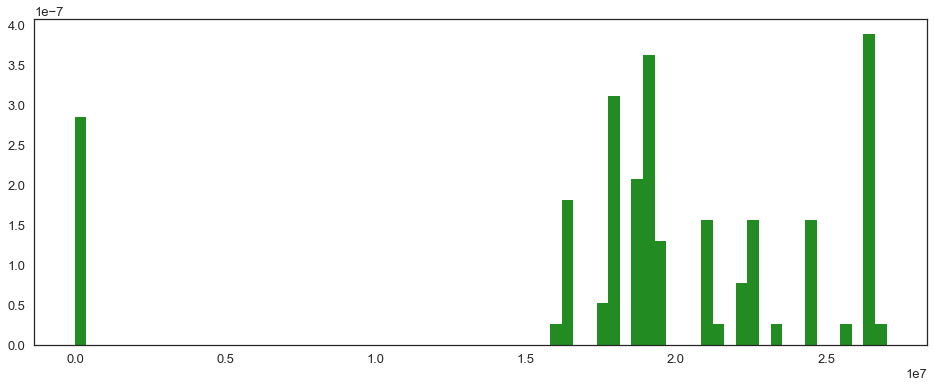

In [27]:
figsize(16, 6)

#_hist1 = plt.hist(max_volume_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")
volumes = max_volume_trace_L
mask = volumes == 0
masked_trace = volumes[~mask]
_hist1 = plt.hist(max_volume_trace_L, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "forestgreen")
#_hist1 = plt.hist(masked_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

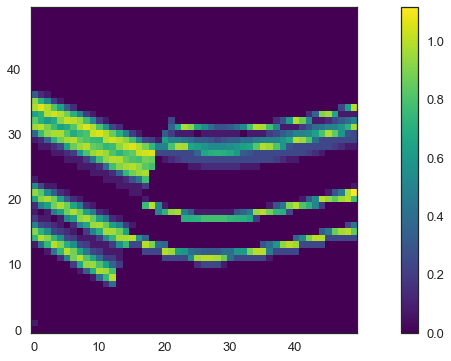

In [30]:
lith_blocks = []
for i in structural_model_trace_L[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

plt.imshow(i_entropy.reshape(50,50,50)[:,0,:].T, origin="lower", cmap="viridis")
plt.colorbar()

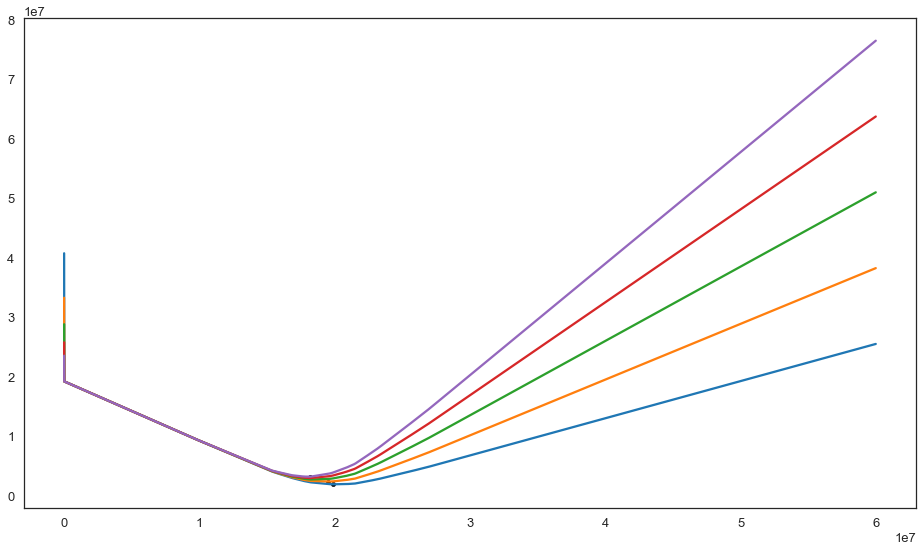

In [33]:
figsize(16, 9)

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss = lambda estimate_s, risk_s: volume_lossR(estimate_s, masked_trace, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss, -40, args=(r,),disp = False)
    #print(_min_score)
    if _min_score < 0:
        _min_score = 0
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss(_min_score,r)
    counter += 1


In [12]:
# DETERMINATION OF LAYER THICKNESSES ON HANGING- AND FOOTWALL BASED ON VOXEL-COUNTING
#fault_block = fault_sol[0,0]
#lith_block = lith_sol[0,0]
#th_factor = scale_factor
#
## Finding fault tips, upper and lower
#def find_fault_tips(fault_block):
#    fault_reshape = fault_block.reshape(50,50,50)
#    upper_fault_tip = np.count_nonzero(fault_reshape[:,25,49])+1
#    lower_fault_tip = np.count_nonzero(fault_reshape[:,25,0])-1
#    return upper_fault_tip, lower_fault_tip
#    
## Footwall thicknesses
#def fw_thicknesses(lith_block, upper_fault_tip, th_factor):
#    lith_reshape = lith_block.reshape(50,50,50)
#    fw_reservoir_count = 0
#    fw_seal_count = 0 
#    fw_sec_res_count = 0 
#    for i in lith_reshape[upper_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            fw_reservoir_count += 1
#            fw_reservoir_thickness = fw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            fw_seal_count += 1
#            fw_seal_thickness = fw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            fw_sec_res_count += 1
#            fw_sec_res_thickness = fw_sec_res_count * th_factor
#    return fw_reservoir_thickness, fw_seal_thickness, fw_sec_res_thickness
#
## Hanging wall thicknesses
#def hw_thicknesses(lith_block, lower_fault_tip, th_factor):
#    hw_reservoir_count = 0
#    hw_seal_count = 0 
#    hw_sec_res_count = 0 
#    for i in lith_reshape[lower_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            hw_reservoir_count += 1
#            hw_reservoir_thickness = hw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            hw_seal_count += 1
#            hw_seal_thickness = hw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            hw_sec_res_count += 1
#            hw_sec_res_thickness = hw_sec_res_count * th_factor
#    return hw_reservoir_thickness, hw_seal_thickness, hw_sec_res_thickness

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS IN INTERP_DATA

# Footwall at X = 1600 and Y = 1000
#def fw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (1400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    
#    fw_rb_z = points_fw[res_bot_cond]['Z'].values*rescale_f
#    fw_sb_z = points_fw[seal_bot_cond]['Z'].values*rescale_f
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z'].values*rescale_f
#    fw_ob_z = points_fw[over_bot_cond]['Z'].values*rescale_f
#    
#    fw_res_th = np.abs(fw_sb_z-fw_rb_z)
#    fw_seal_th = np.abs(fw_r2b_z-fw_sb_z)
#    fw_sec_res_th = np.abs(fw_ob_z-fw_r2b_z)
#    return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z
#
## Hanging wall at X = 600 and Y = 1000
#def hw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    hw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_hw = interp_data.geo_data_res.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)*rescale_f
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)*rescale_f
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)*rescale_f
#    return hw_res_th, hw_seal_th, hw_sec_res_th

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS USING GEO_DATA
#res_bot_cond = geo_data.interfaces['formation'] == 'Reservoir'
#seal_bot_cond = geo_data.interfaces['formation'] == 'Seal'
#sec_res_bot_cond = geo_data.interfaces['formation'] == 'SecondaryReservoir'
#over_bot_cond = geo_data.interfaces['formation'] == 'Overlying'
#
#fw_x_cond = geo_data.interfaces['X'] == 1600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_fw = geo_data.interfaces[fw_x_cond]
#points_fw = points_fw[y_mid]
## finding Z-values for each layer bottom
#fw_rb_z = points_fw[res_bot_cond]['Z']
#fw_sb_z = points_fw[seal_bot_cond]['Z']
#fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#fw_ob_z = points_fw[over_bot_cond]['Z']
#
#fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
#hw_x_cond = geo_data.interfaces['X'] == 600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_hw = geo_data.interfaces[hw_x_cond]
#points_hw = points_hw[y_mid]
## finding Z-values for each layer bottom
#hw_rb_z = points_hw[res_bot_cond]['Z']
#hw_sb_z = points_hw[seal_bot_cond]['Z']
#hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#hw_ob_z = points_hw[over_bot_cond]['Z']
#
#hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)
#
## Footwall
#def fw_thicknesses():
#    fw_x_cond = geo_data.interfaces['X'] == 1600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_fw = geo_data.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    # finding Z-values for each layer bottom
#    fw_rb_z = points_fw[res_bot_cond]['Z']
#    fw_sb_z = points_fw[seal_bot_cond]['Z']
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#    fw_ob_z = points_fw[over_bot_cond]['Z']
#    
#    fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#    fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#    fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
## Hanging wall
#def hw_thicknesses():
#    hw_x_cond = geo_data.interfaces['X'] == 600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_hw = geo_data.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    # finding Z-values for each layer bottom
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)

In [206]:
#@pymc.deterministic
#def fault_tips(fault_sol=pos_unc_model[1]):
#    fault = fault_sol[0,0]
#    return find_fault_tips(fault)    
#
#@pymc.deterministic
#def fw_th(lith_sol=pos_unc_model[0], upper_fault_tip=fault_tips[0]):
#    lith = lith_sol[0,0]
#    #print("FOOTWALL RES THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[0])
#    #print("FOOTWALL SEAL THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[1])
#    return fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)
#
#@pymc.deterministic
#def hw_th(lith_sol=pos_unc_model[0], lower_fault_tip=fault_tips[1]):
#    lith = lith_sol[0,0]
#    return hw_thicknesses(lith, lower_fault_tip, th_factor=scale_factor)

In [248]:
#a,b = np.gradient(grid_z0, 40.81632614)
#a = np.rot90(a,-1)
#
#asign = np.sign(a)
#asignchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
#
##print(asignchange)
#asignchange2 = ((np.roll(asign, -1) - asign) != 0).astype(int)
#
#
#asc3 = np.logical_or(asignchange, asignchange2)
#
#asc3[:,0]= 0
#asc3[:,1]= 0
#asc3[:,-1] = 0
#asc3[-1,:] = 0
#print(asc3)
#
#bsign = np.sign(b)
#bsignchange = ((np.roll(bsign, 1) - bsign) != 0).astype(int)
#bsignchange2 = ((np.roll(bsign, -1) - bsign) != 0).astype(int)
#
#bsc3 = np.logical_or(bsignchange, bsignchange2)
#
#bsc3[:,0]= 0
#bsc3[:,-1] = 0
#bsc3[:,-2] = 0
#bsc3[:,-3] = 0
#bsc3[-1,:] = 0
##print(bsignchange)
#
#
#asignchange = np.rot90(asignchange,1)
#asc3 = np.rot90(asc3,1)
#
#c = np.logical_and(asc3,bsc3)

[[False False  True False False False False False False False False False
  False False False False False False False False False False False False
  False  True  True False False False False False False False False False
  False False False False False False False False False False False  True
   True False]
 [False False  True False False False False False False False False False
  False False False False False False False False False False False False
  False  True  True False False False False False False False False False
  False False False False False False False False False False  True  True
  False False]
 [False False  True  True False False False False False False False False
  False False False False False False False False False False False False
  False  True  True False False False False False False False False False
  False False False False False False False False False False  True  True
  False False]
 [False False  True  True False False False False False False False

In [333]:
#grad_zero = saddle_p_all == 1
#grid_z0[~grad_zero]= np.nan
#grid_z0

array([[           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,

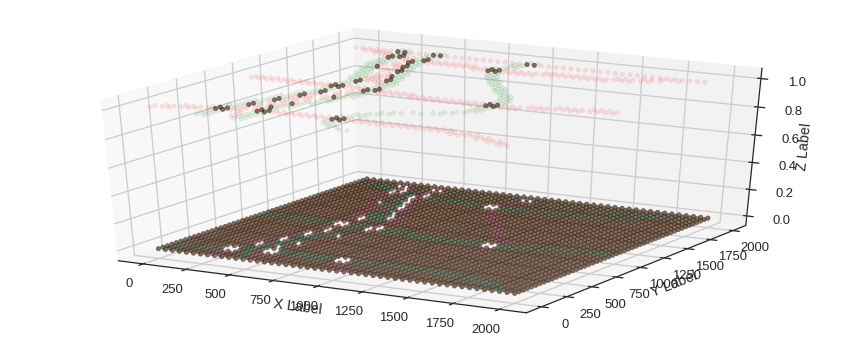

In [249]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
##ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
#ax.scatter(grid_x, grid_y, asc3, c="r", alpha = 0.1)
#ax.scatter(grid_x, grid_y, bsc3, c="g", alpha = 0.1)
#ax.scatter(grid_x, grid_y, c, c="black", alpha = 0.5)
#
#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
#
#plt.show()

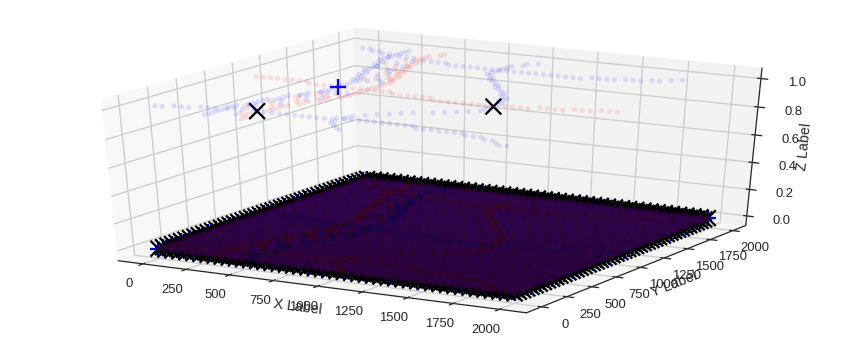

In [372]:
#fault_line = grid_minX[grid_maxX]
#figsize(15,6)
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
##ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
#ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
#ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
#ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
#ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
#ax.scatter(grid_x, grid_y, spill_points, c="black", alpha = 1, marker='x', s = 250)
#ax.scatter(grid_x, grid_y, leak_point, c="b", alpha = 1, marker='+', s= 250)
#
#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
#
#plt.show()

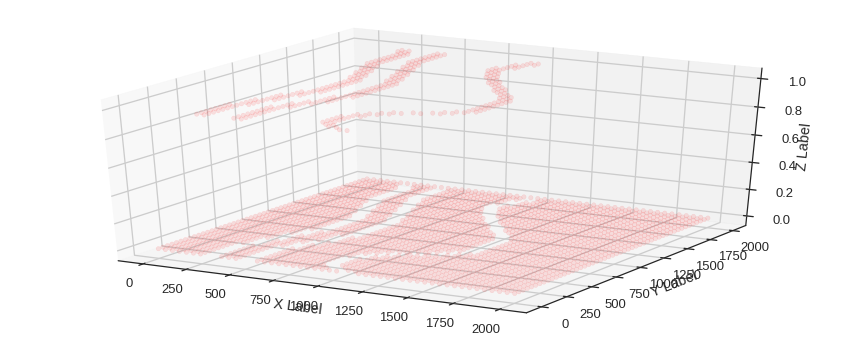

In [245]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
##ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
##ax.scatter(grid_x, grid_y, -a, c="r", alpha = 0.1)
##ax.scatter(grid_x, grid_y, -asignchange, c="g", alpha = 0.1)
#ax.scatter(grid_x, grid_y, bsc3, c="r", alpha = 0.1)
#
#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
#
#plt.show()

In [38]:
# SPILL AND LEAK POINT FUNCTIONS

# Finding the spill point
#def spill_point(res_surface):
#    mini = argrelextrema(res_surface[:,2], np.less, order=10)
#    minima = np.array(list(zip(np.take(res_surface[:,1], mini[0]), np.take(res_surface[:,0], mini[0]), np.take(res_surface[:,2], mini[0]))))
#    fault_thresh = minima[:,1] > 700 #taking only relevant side by setting a threshold visually estimated, best: 20
#    spill_min_line = minima[fault_thresh]
#    spill_pos = np.array(np.argmax(spill_min_line[:,2]))
#    spill_z = np.take(spill_min_line[:,2], spill_pos)
#    spill_p = np.array([np.take(spill_min_line[:,1], spill_pos), np.take(spill_min_line[:,0],
#                                spill_pos), np.take(spill_min_line[:,2], spill_pos)])
#    
#    # Horizontal plane defined by z-pos of spill
#    if True:
#        spill_bottom = np.ones_like(res_surface)
#        spill_bottom[:,0] = res_surface[:,0]
#        spill_bottom[:,1] = res_surface[:,1]
#        spill_bottom[:,2] = spill_z    
#    
#    return spill_z, spill_p, spill_min_line, spill_bottom
#
## Finding the leak point ( critically inefficient method! takes 10s!)
#def leak_point(res_surface):
#    counter = 0
#    # Creating empty lists and arrays to save values
#    xvals = []
#    yvals = []
#    zvals = []
#    leak_min = np.empty((0,3), dtype=int)
#    #leak_min = np.empty([3,], dtype=int)
#    
#    for i in np.unique(res_surface[:,1]):
#        
#    #while counter < model_size:
#        #print(counter)
#        for e in res_surface:
#            # Looking at a slice along y-axis for y = e[1] = counter, 
#            # and appending x,y,z-values into lists
#            # This is a way of RESORTING the array as needed
#            #if int(e[1]) == counter:
#            if e[1] == i:
#                xvals.append(e[0])
#                yvals.append(e[1])
#                zvals.append(e[2])
#            
#        # Saving x,y,z-values as lists/arrays      
#        zvals = np.array(zvals)
#        yvals = np.array(yvals)
#        xvals = np.array(xvals)
#
#        # Looking fore minima positions in z-array
#        min_pos = argrelextrema(zvals, np.less, order=10)
#        
#        # Saving x,y,z-positions of minima
#        ypos = yvals[min_pos]
#        xpos = xvals[min_pos]
#        mins = zvals[min_pos]
#        
#        # Condition: Check if any minimum was found and if any data is given at y = counter
#        # If no minimum found, restart loop at next iteration
#        # This way, we can work with the data that coesn't cover every 1 step along the model
#        # (such as the surface vertices)
#        if len(mins) == 0:
#            counter += 1
#            #lists have to be emptied again
#            xvals = []
#            yvals = []
#            zvals = []
#            continue
#        
#        #np.append(leak_min, mins) -----> what did I use this for?
#        
#        # Create and array element to save coordinates of minima
#        mins_pos = np.array(list(zip(xpos, ypos, mins)))
#        # Save minima of slice into array of ALL minima
#        leak_min = np.vstack((leak_min, mins_pos))
#
#        # Empty lists for next iteration
#        xvals = []
#        yvals = []
#        zvals = []
#    
#        counter += 1
#        
#    #leak_min = np.delete(leak_min, 0, 0) #what does this do???
#    
#    # Result of the loop above is one or SEVERAL lines of minima ("leak lines")
#    # only want to look at the line bordering the fault surface
#    # need for a general function/method to limit to only that line!
#    # For now: Taking only relevant side by setting a threshold that is visually estimated
#    near_fault_thresh = leak_min[:,0] < 1500
#    leak_line = leak_min[near_fault_thresh]
#    
#    # The highest point of the leak line is the leak point!
#    leak_pos = np.array(np.argmax(leak_line[:,2]))
#    leak_z = np.take(leak_line[:,2], leak_pos)
#
#    # Full coordinates of the leak point as array element
#    leak_p = np.array([np.take(leak_line[:,1], leak_pos), np.take(leak_line[:,0], leak_pos), np.take(leak_line[:,2], leak_pos)])
#    
#    # Creating a horizontal plane defined by the leak point z-position, in shape of res_surface
#    leak_bottom = np.ones_like(res_surface)
#    leak_bottom[:,0] = res_surface[:,0]
#    leak_bottom[:,1] = res_surface[:,1]
#    leak_bottom[:,2] = leak_z
#   
#    return leak_z, leak_p, leak_line, leak_bottom

### PLOTTING SP, LP and TRAP
#def plot_spill(res_surface, spill_min_line, spill_p):
#    fig = plt.figure()
#    ax = fig.add_subplot(111, projection='3d')
#    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
#    ax.scatter(-spill_min_line[:,0], -spill_min_line[:,1], spill_min_line[:,2], c='r', s = 50)
#    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 200)
#    
#    ax.set_xlabel('X Label')
#    ax.set_ylabel('Y Label')
#    ax.set_zlabel('Z Label')
#
#    plt.show()
#
#def plot_leak(res_surface, leak_line, leak_p):
#    fig = plt.figure()
#    ax = fig.add_subplot(111, projection='3d')
#    
#    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
#    ax.scatter(-leak_line[:,1], -leak_line[:,0], leak_line[:,2], c='r', s = 50)
#    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 200)
#    
#    ax.set_xlabel('X Label')
#    ax.set_ylabel('Y Label')
#    ax.set_zlabel('Z Label')
#    
#    plt.show()
#    
#def plot_trap(res_surface, bottom_surface, spill_p, leak_p):
#    fig = plt.figure()
#    ax = fig.add_subplot(111, projection='3d')
#    ax.scatter(-bottom_surface[:,1], -bottom_surface[:,0], bottom_surface[:,2], c="r", alpha = 0.05)
#    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
#    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 1000)
#    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 1000)
#
#    
#    ax.set_xlabel('X Label')
#    ax.set_ylabel('Y Label')
#    ax.set_zlabel('Z Label')
#    
#    plt.show()